 Below is a complete code example that combines the MNIST, EMNIST, and IAM datasets to train a neural network model capable of recognizing numbers, letters (both upper and lower case), and cursive handwriting using Google Colab. I'll include explanations for each step.
Full Code with Explanations

Step 1: Set Up Environment and Import Libraries

First, we need to set up our environment and import the necessary libraries.

In [1]:
# Install TensorFlow and necessary libraries (run this if not already installed)
# !pip install tensorflow opencv-python-headless numpy matplotlib emnist scipy

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape, GRU, Bidirectional, TimeDistributed
import numpy as np
import cv2
import os
import urllib.request
import tarfile
import struct
import scipy.io
import gzip
import matplotlib.pyplot as plt

Step 2: Load and Preprocess the Datasets

We'll load the MNIST and EMNIST datasets using TensorFlow's built-in functions. For the IAM dataset, we need to preprocess the images manually.

Start from NMIST

In [3]:
# Load MNIST and EMNIST datasets
mnist = tf.keras.datasets.mnist

(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = mnist.load_data()

# Normalize the data
X_mnist_train = X_mnist_train.astype('float32') / 255.0
X_mnist_test = X_mnist_test.astype('float32') / 255.0

# Reshape to add channel dimension (28x28 images, 1 channel)
X_mnist_train = X_mnist_train.reshape(-1, 28, 28, 1)
X_mnist_test = X_mnist_test.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_mnist_train = tf.keras.utils.to_categorical(y_mnist_train, num_classes=10)  # 10 classes for digits
y_mnist_test = tf.keras.utils.to_categorical(y_mnist_test, num_classes=10)

Now the EMNIST part

In [4]:
# Create a directory to store the dataset
dataset_dir = 'emnist'
os.makedirs(dataset_dir, exist_ok=True)

# Download the EMNIST dataset
url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
zip_path = os.path.join(dataset_dir, "emnist.zip")
urllib.request.urlretrieve(url, zip_path)

# Extract the zip file
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

Define Helper Functions to Load the Data

We'll define functions to load the images and labels from the idx format used in the EMNIST dataset.

In [5]:
def load_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        # Read the header information
        magic_number, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        image_data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols, 1)
        return image_data.astype('float32') / 255.0

def load_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        # Read the header information
        magic_number, num_labels = struct.unpack(">II", f.read(8))
        # Read the label data
        label_data = np.frombuffer(f.read(), dtype=np.uint8)
        return label_data

In [6]:
# File paths
train_images_path = 'emnist/gzip/emnist-byclass-train-images-idx3-ubyte.gz'
train_labels_path = 'emnist/gzip/emnist-byclass-train-labels-idx1-ubyte.gz'
test_images_path = 'emnist/gzip/emnist-byclass-test-images-idx3-ubyte.gz'
test_labels_path = 'emnist/gzip/emnist-byclass-test-labels-idx1-ubyte.gz'

# Load the data
X_emnist_train = load_images(train_images_path)
y_emnist_train = load_labels(train_labels_path)
X_emnist_test = load_images(test_images_path)
y_emnist_test = load_labels(test_labels_path)

# Convert labels to one-hot encoding
y_emnist_train = tf.keras.utils.to_categorical(y_emnist_train, num_classes=62) # assume 62 classes for the combined dataset
y_emnist_test = tf.keras.utils.to_categorical(y_emnist_test, num_classes=62)


Combine MNIST and EMNIST

The mismatch in shapes between y_mnist_train (shape (60000, 10)) and y_emnist_train (shape (697932, 62)) occurs because MNIST has 10 classes (digits 0-9), while EMNIST has 62 classes (digits, uppercase, and lowercase letters). To combine these datasets, we need to adjust the labels to a consistent shape.
Approach to Combine Datasets:

    Expand MNIST Labels: Expand the MNIST labels to match the EMNIST format by padding with zeros.

    Combine the Labels: Concatenate the expanded MNIST labels with the EMNIST labels.

In [7]:
# Expand MNIST labels from (60000, 10) to (60000, 62)
num_classes_emnist = 62
num_classes_mnist = 10

y_mnist_train_expanded = np.zeros((y_mnist_train.shape[0], num_classes_emnist))
y_mnist_test_expanded = np.zeros((y_mnist_test.shape[0], num_classes_emnist))

y_mnist_train_expanded[:, :num_classes_mnist] = y_mnist_train
y_mnist_test_expanded[:, :num_classes_mnist] = y_mnist_test


In [8]:
# Combine with MNIST if necessary (assuming X_mnist_train, y_mnist_train are already loaded)
X_train_combined = np.concatenate((X_mnist_train, X_emnist_train), axis=0)
y_train_combined = np.concatenate((y_mnist_train_expanded, y_emnist_train), axis=0)

X_test_combined = np.concatenate((X_mnist_test, X_emnist_test), axis=0)
y_test_combined = np.concatenate((y_mnist_test_expanded, y_emnist_test), axis=0)


Step 4: Define the Neural Network Model

We define the model architecture that can handle the complexity of letters, numbers, and cursive handwriting.

In [9]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(62, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       2

In [10]:
# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(X_train_combined, y_train_combined.argmax(axis=1),
        epochs=50, validation_data=(X_test_combined, y_test_combined.argmax(axis=1)),
        callbacks=[early_stopping, model_checkpoint]
        )

Epoch 1/50
23686/23686 [==============================] - 445s 19ms/step - loss: 0.7091 - accuracy: 0.7741 - val_loss: 0.4532 - val_accuracy: 0.8439
Epoch 2/50
23686/23686 [==============================] - 561s 24ms/step - loss: 0.5495 - accuracy: 0.8164 - val_loss: 0.4228 - val_accuracy: 0.8517
Epoch 3/50
23686/23686 [==============================] - 537s 23ms/step - loss: 0.5152 - accuracy: 0.8260 - val_loss: 0.4081 - val_accuracy: 0.8550
Epoch 4/50
23686/23686 [==============================] - 449s 19ms/step - loss: 0.4975 - accuracy: 0.8309 - val_loss: 0.4131 - val_accuracy: 0.8552
Epoch 5/50
23686/23686 [==============================] - 436s 18ms/step - loss: 0.4892 - accuracy: 0.8334 - val_loss: 0.3979 - val_accuracy: 0.8587
Epoch 6/50
23686/23686 [==============================] - 426s 18ms/step - loss: 0.4835 - accuracy: 0.8353 - val_loss: 0.3980 - val_accuracy: 0.8583
Epoch 7/50
23686/23686 [==============================] - 460s 19ms/step - loss: 0.4799 - accuracy: 0.8360

Step 6: Evaluate and Save the Model

After training, evaluate the model and save it.

In [12]:
loss, accuracy = model.evaluate(X_test_combined, y_test_combined.argmax(axis=1))
print(f'Test accuracy: {accuracy:.4f}')

3948/3948 [==============================] - 24s 6ms/step - loss: 0.3882 - accuracy: 0.8613
Test accuracy: 0.8613


Also make a plot

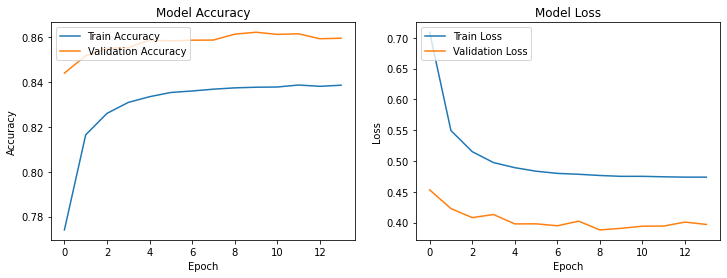

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [14]:
# Save the trained model
model.save('combined_handwriting_model.keras')

Step 7: Download the Model to Local Machine

Finally, download the model to use in your local PyCharm setup.

In [15]:
# from google.colab import files
# files.download('combined_handwriting_model.keras')

Not a good sign. Model accuracy graph result looks a bit off. Need another model config.

In [16]:
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Reshape((-1, 256)),  # Reshape for GRU layers
    Bidirectional(GRU(128, return_sequences=True)),
    TimeDistributed(Dense(128, activation='relu')),
    TimeDistributed(Dense(62, activation='softmax')),  # Wrap with TimeDistributed
    Flatten(),
    Dense(62, activation='softmax')  # Assuming 62 classes for the combined dataset
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 11, 11, 128)      512       
 hNormalization)                                                 
                                                      

In [17]:
# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_combined_v2.keras', save_best_only=True, monitor='val_loss')

# Train the model
history2 = model2.fit(X_train_combined, y_train_combined,  # Remove argmax 
        epochs=50, validation_data=(X_test_combined, y_test_combined),  # Remove argmax
        callbacks=[early_stopping, model_checkpoint]
        )

Epoch 1/50
23686/23686 [==============================] - 835s 35ms/step - loss: 1.5499 - accuracy: 0.5647 - val_loss: 0.7511 - val_accuracy: 0.7985
Epoch 2/50
23686/23686 [==============================] - 877s 37ms/step - loss: 0.6295 - accuracy: 0.8227 - val_loss: 0.5615 - val_accuracy: 0.8324
Epoch 3/50
23686/23686 [==============================] - 884s 37ms/step - loss: 0.5124 - accuracy: 0.8423 - val_loss: 0.4838 - val_accuracy: 0.8468
Epoch 4/50
23686/23686 [==============================] - 934s 39ms/step - loss: 0.4678 - accuracy: 0.8501 - val_loss: 0.4627 - val_accuracy: 0.8533
Epoch 5/50
23686/23686 [==============================] - 910s 38ms/step - loss: 0.4412 - accuracy: 0.8557 - val_loss: 0.4432 - val_accuracy: 0.8575
Epoch 6/50
23686/23686 [==============================] - 889s 38ms/step - loss: 0.4234 - accuracy: 0.8597 - val_loss: 0.4373 - val_accuracy: 0.8570
Epoch 7/50
23686/23686 [==============================] - 881s 37ms/step - loss: 0.4083 - accuracy: 0.8631

In [19]:
loss, accuracy = model2.evaluate(X_test_combined, y_test_combined)
print(f'Test accuracy: {accuracy:.4f}')

3948/3948 [==============================] - 64s 16ms/step - loss: 0.3887 - accuracy: 0.8687
Test accuracy: 0.8687


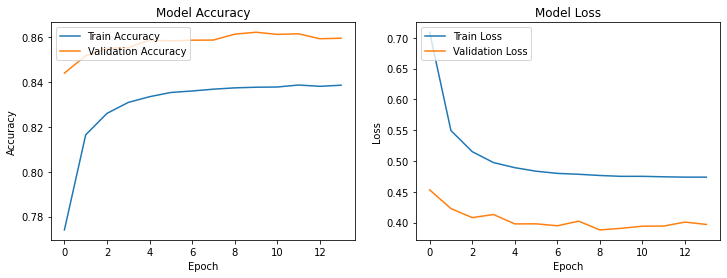

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [22]:
# Save the trained model
model2.save('combined_handwriting_model_v2.keras')